In [10]:
import os
import re
import pandas as pd
import json
import requests
import time


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 2, 'ytick.major.width': 1, 'ytick.major.size': 2})
from matplotlib.backends.backend_pdf import PdfPages

In [11]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

def create_dot_plot(go_file, terms_col="Term", odds_ratio_col="odds_ratio", gene_col="genes", gene_pval_col="adj_pval", ncat=20, figsize=(5,7)):
    # read and parse go file
    go_df = pd.read_csv(go_file)
    go_df[terms_col] = go_df[terms_col].apply(lambda x: x[0].upper() + x[1:])
    go_df["gene_counts"] = go_df[gene_col].apply(lambda x: len(x.split("|")))
    go_df_adj = go_df.loc[go_df[gene_pval_col]<0.05]
    plot_df = go_df_adj.sort_values(gene_pval_col).head(ncat)
    
    plot_df = plot_df.sort_values(odds_ratio_col, ascending=False)
    fig, axes = plt.subplots(figsize=figsize)
    norm = plt.Normalize(0, 0.05) # plot_df['qvalue'].min(), plot_df['qvalue'].max()
    sns_ax = sns.scatterplot(
        data=plot_df, x=odds_ratio_col, y=terms_col, 
        size="gene_counts", hue=gene_pval_col, ax=axes, sizes=(100, 300), palette='RdBu', hue_norm=norm, linewidth=0.5, edgecolor="k"
        )
    sns_ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=1)
    sns_ax.set_xlabel("Gene ratio")
    sns_ax.set_ylabel("")
    sns_ax.set_axisbelow(True)
    sns_ax.yaxis.grid(ls="--", which="major")
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    sns_ax.figure.colorbar(sm, ax=axes, shrink=0.25, aspect=5, ticks=[0, 0.01, 0.05])
    # axes.margins(x=0.1, y=0.1)
    return fig, axes

def save_enrichr_results(results, save_file):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    with open(save_file, "w") as f:
        f.write("Term,p_val,adj_pval,odds_ratio,combined_score,genes\n")
        for lines in results:
            if lines[2]<0.05:
                f.write(f"{lines[1].replace(',', '')},{lines[2]},{lines[6]},{lines[3]},{lines[4]},{'|'.join(lines[5])}\n")
    return

def run_enrichment_helper(study_genes, population_genes, enrich_database, save_file):
    # upload geneset
    base_url = "https://maayanlab.cloud/speedrichr"
    description = f"Rarecomb gene set enrichment in {enrich_database}"
    study_res = requests.post(
        f"{base_url}/api/addList",
        files=dict(list=(None, '\n'.join(study_genes)), description=(None, description))
        )
    if study_res.ok:
        userlist_response = study_res.json()
        userListId=userlist_response["userListId"]
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to study gene posting failure")

    # upload background
    pop_res = requests.post(
        f"{base_url}/api/addbackground",
        data=dict(background='\n'.join(population_genes))
    )
    if pop_res.ok:
        background_response = pop_res.json()
        backgroundid=background_response["backgroundid"]
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to pop gene posting failure")

    # run enrichment
    enrich_res = requests.post(
            f"{base_url}/api/backgroundenrich",
            data=dict(
            userListId=userListId,
            backgroundid=backgroundid,
            backgroundType=enrich_database,
            )
        )
    if enrich_res.ok:
        try:
            results = json.loads(enrich_res.text)[enrich_database]
            save_enrichr_results(results, save_file)
        except:
            print(f"Results could not be decoded for {enrich_database}")
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to run enrichment failure")
    return

def run_enrichment(study_genes, population_genes, save_dir, enrich_database=["Allen_Brain_Atlas_10x_scRNA_2021", "dbGaP", "GO_Biological_Process_2023", "GTEx_Tissues_V8_2023", "GWAS_Catalog_2023", "Human_Phenotype_Ontology", "KEGG_2021_Human", "MGI_Mammalian_Phenotype_Level_4_2021", "OMIM_Disease"]):
    for ed in enrich_database:
        print(ed)
        enrich_file = os.path.join(save_dir, f"{ed}_enrich.csv")
        run_enrichment_helper(study_genes, population_genes, ed, enrich_file)
        fig, ax = create_dot_plot(enrich_file, ncat=20)
        ax.set_title(f"{ed}")
        fig_save_dir = os.path.join(save_dir, "figures")
        os.makedirs(fig_save_dir, exist_ok=True)
        fig_save_file = os.path.join(fig_save_dir, f"{ed}.pdf")
        save_pdf(fig_save_file, fig)
        time.sleep(30)
    return


In [12]:
sig_meta_res_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")
save_dir = "../data/functional_enrichment/"

In [13]:
aou_df = pd.read_csv("../data/meta/bmi_aou_meta_w_samples.csv.gz")
ukb_df = pd.read_csv("../data/meta/bmi_ukb_meta_w_samples.csv.gz")
meta_df = pd.concat([aou_df, ukb_df])

In [14]:
def get_genes(ID):
    pattern = re.compile("(.+)\.(PTV.*)\.0\.001")
    m = re.match(pattern, ID)
    if not m:
        print(ID)
    gene = m.group(1)
    return gene

In [18]:
meta_df["gene"] = meta_df.ID.apply(get_genes)
sig_meta_res_df["gene"] = sig_meta_res_df.ID.apply(get_genes)

In [19]:
pop_genes = set(meta_df.gene.unique())

In [20]:
risk_genes = set(sig_meta_res_df.loc[sig_meta_res_df.beta>0, "gene"].unique())
protective_genes = set(sig_meta_res_df.loc[sig_meta_res_df.beta<0, "gene"].unique())
all_genes = set(sig_meta_res_df.loc[:, "gene"].unique())

In [21]:
len(risk_genes),  len(protective_genes), len(all_genes)

(55, 66, 121)

risk
Allen_Brain_Atlas_10x_scRNA_2021
dbGaP


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GO_Biological_Process_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GTEx_Tissues_V8_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GWAS_Catalog_2023
Human_Phenotype_Ontology


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KEGG_2021_Human


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MGI_Mammalian_Phenotype_Level_4_2021


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


OMIM_Disease
protective
Allen_Brain_Atlas_10x_scRNA_2021


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dbGaP


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GO_Biological_Process_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GTEx_Tissues_V8_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GWAS_Catalog_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Human_Phenotype_Ontology


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KEGG_2021_Human


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MGI_Mammalian_Phenotype_Level_4_2021


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


OMIM_Disease


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meta
Allen_Brain_Atlas_10x_scRNA_2021


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dbGaP


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GO_Biological_Process_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(figsize=figsize)
/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GTEx_Tissues_V8_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GWAS_Catalog_2023


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Human_Phenotype_Ontology


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KEGG_2021_Human


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MGI_Mammalian_Phenotype_Level_4_2021


/var/folders/j0/g67f380n7qs2prtf4gsj3rhm41wrxr/T/ipykernel_27618/4281655699.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns_ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


OMIM_Disease


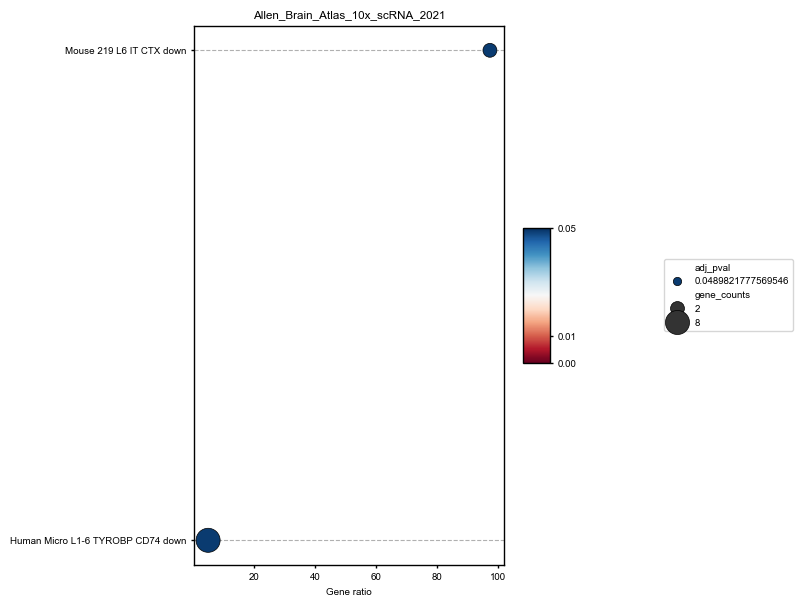

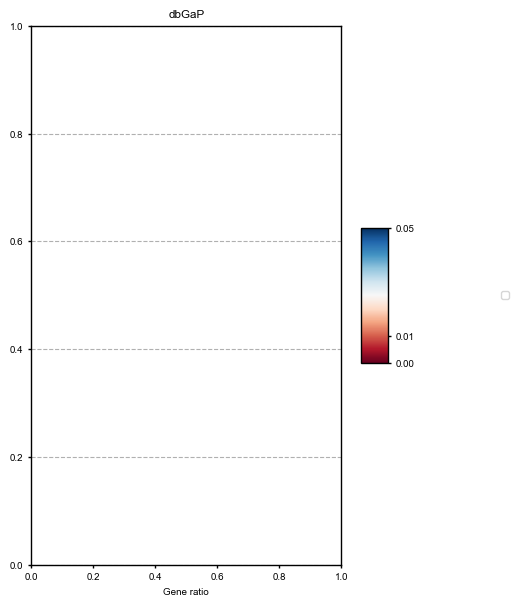

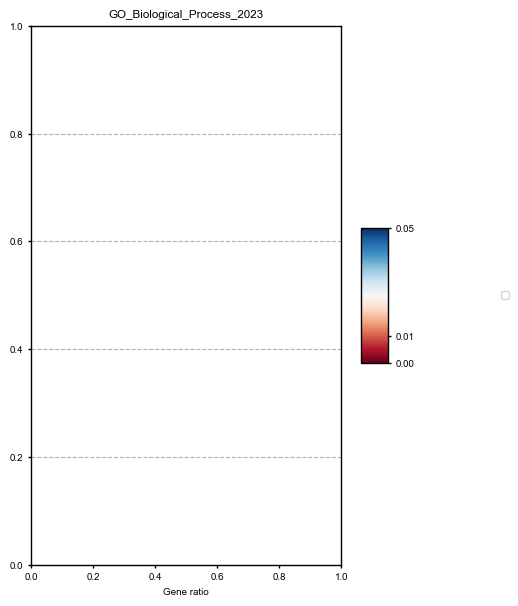

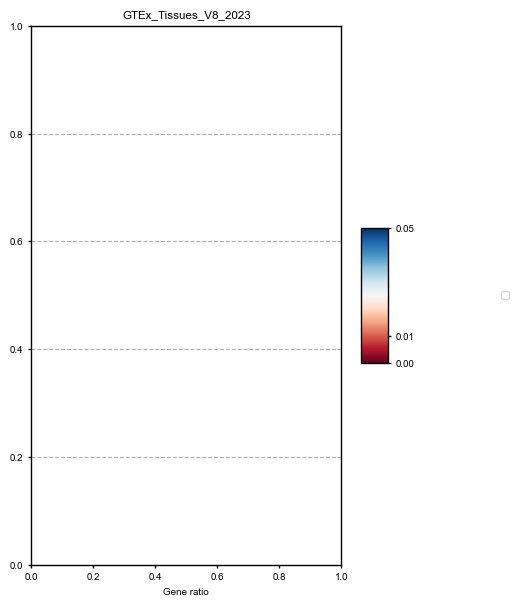

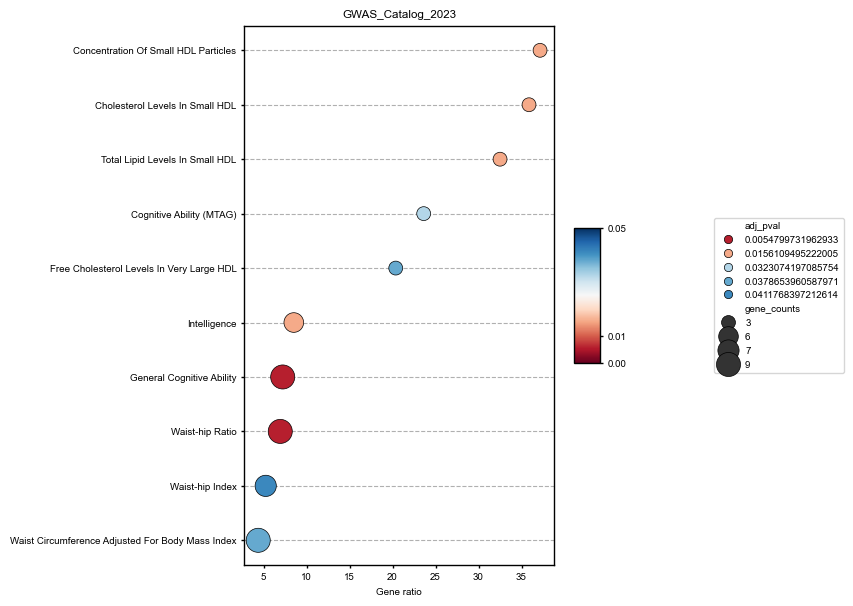

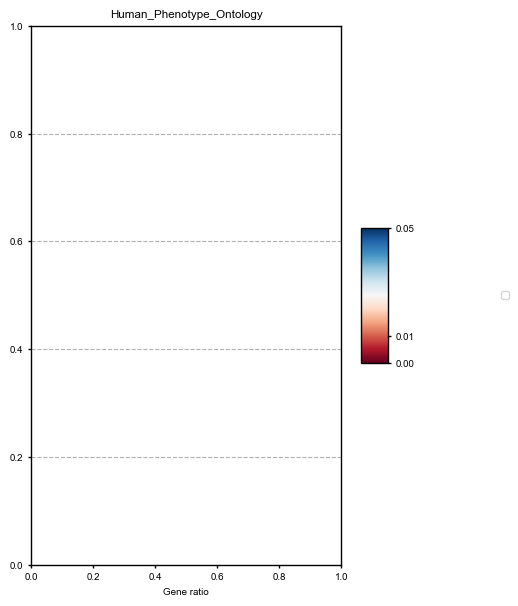

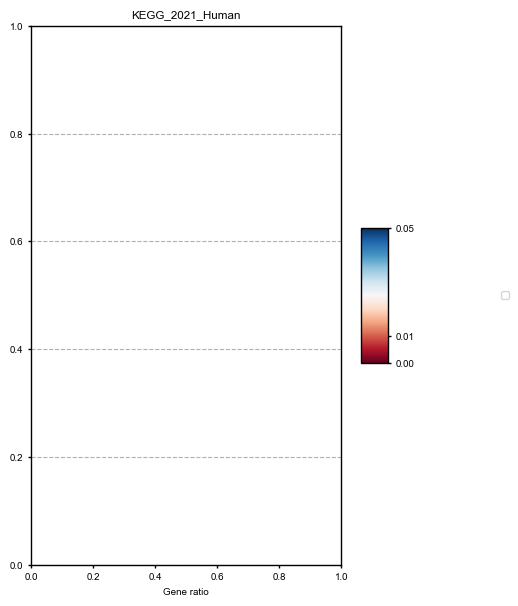

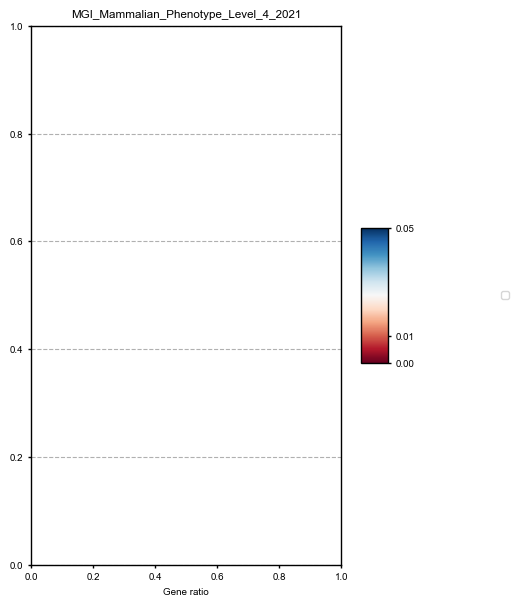

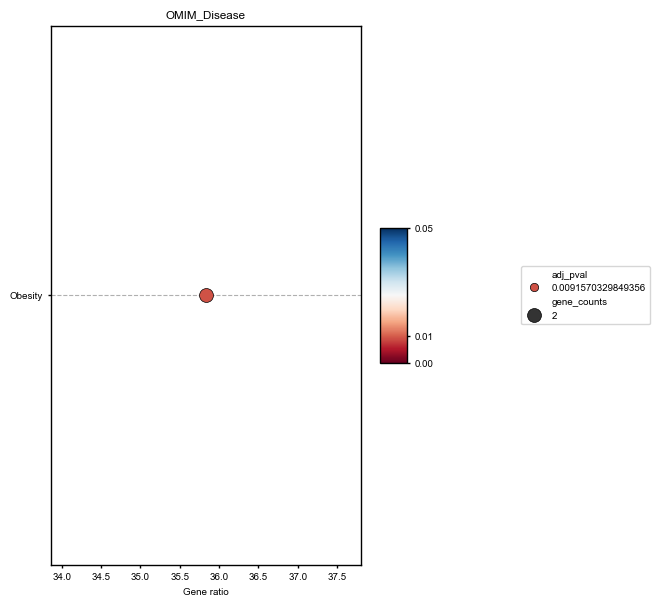

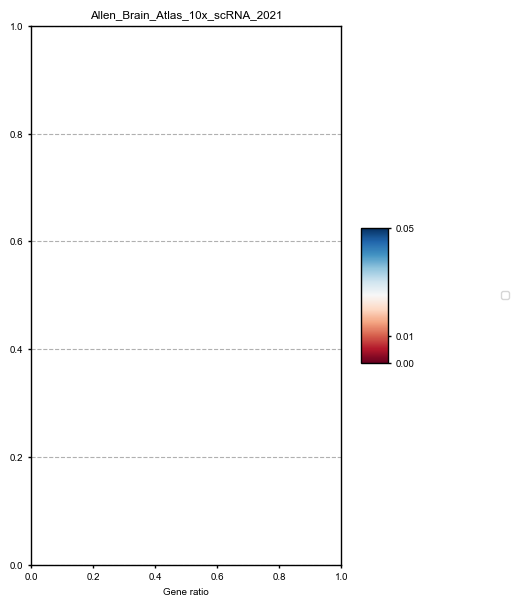

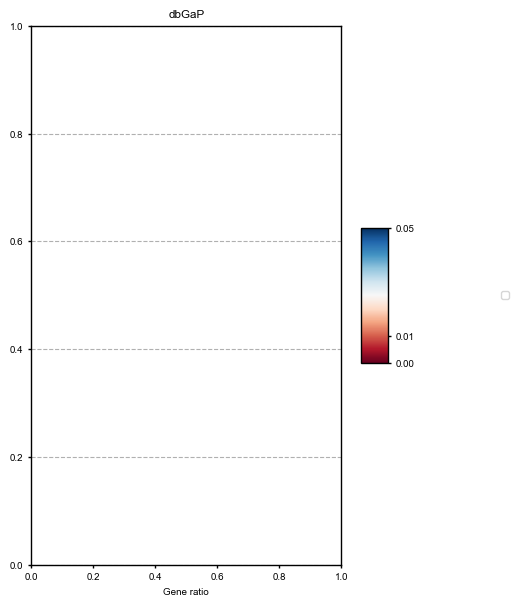

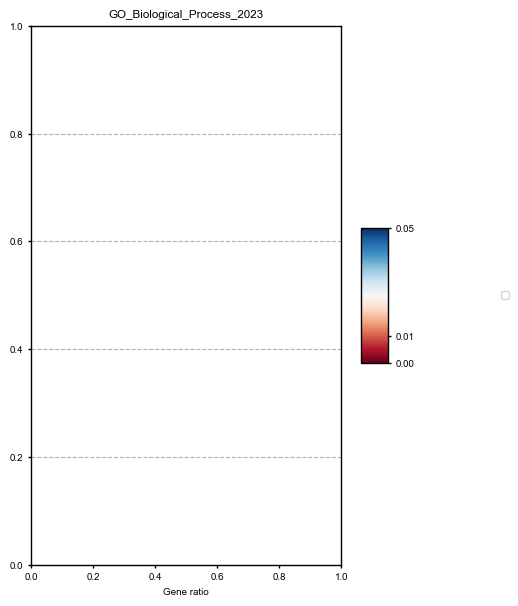

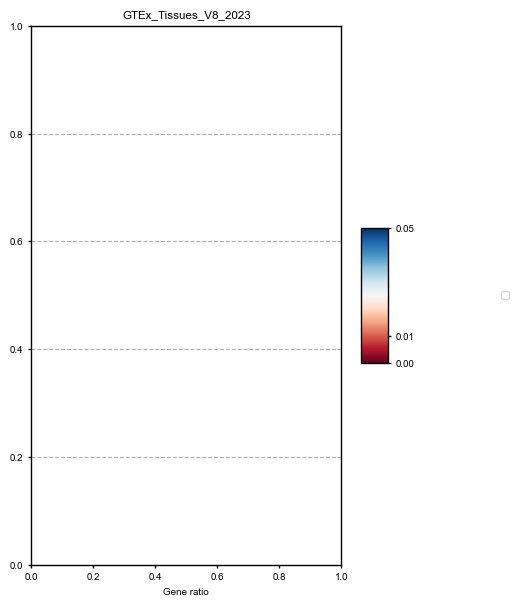

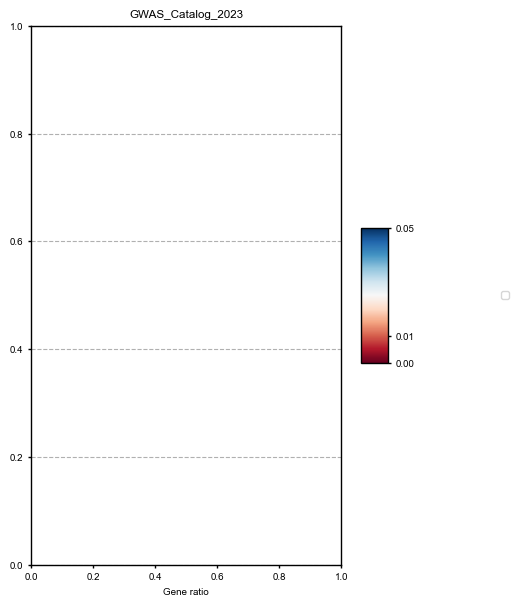

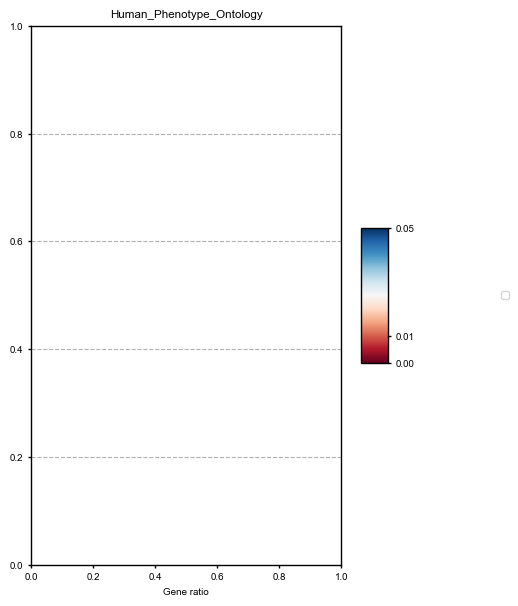

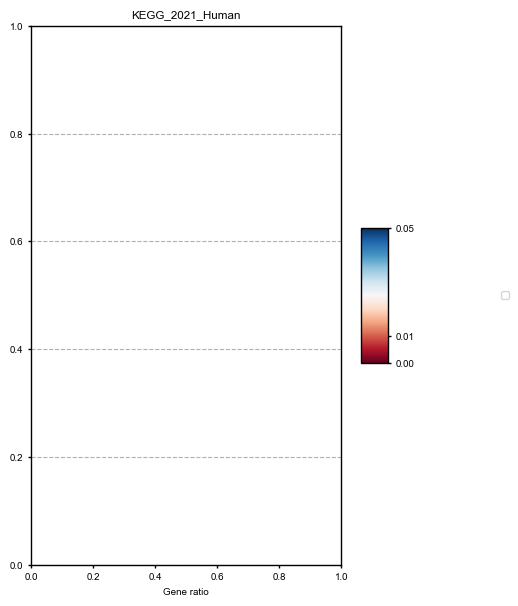

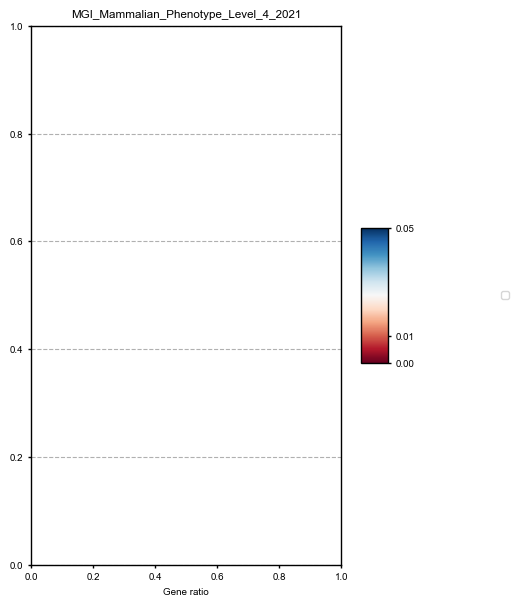

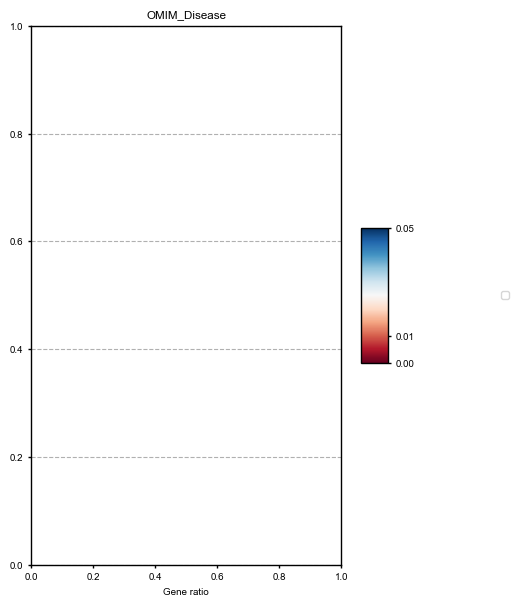

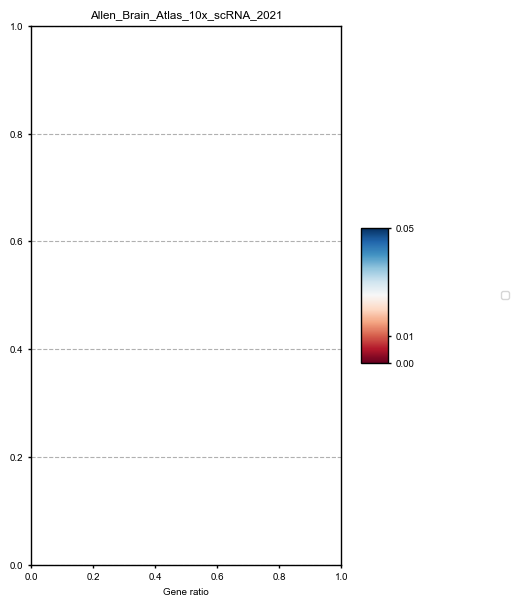

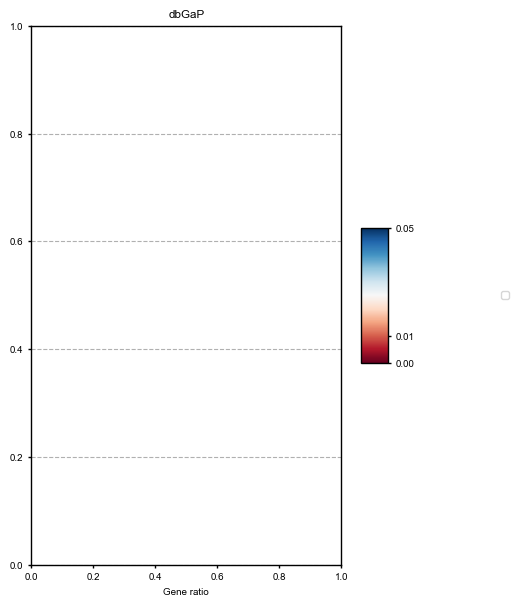

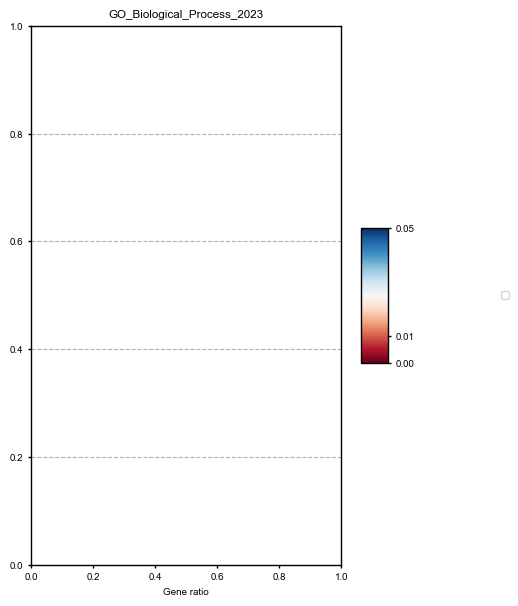

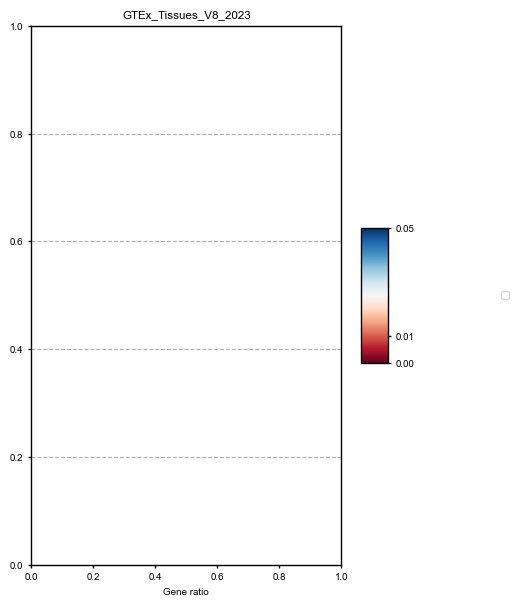

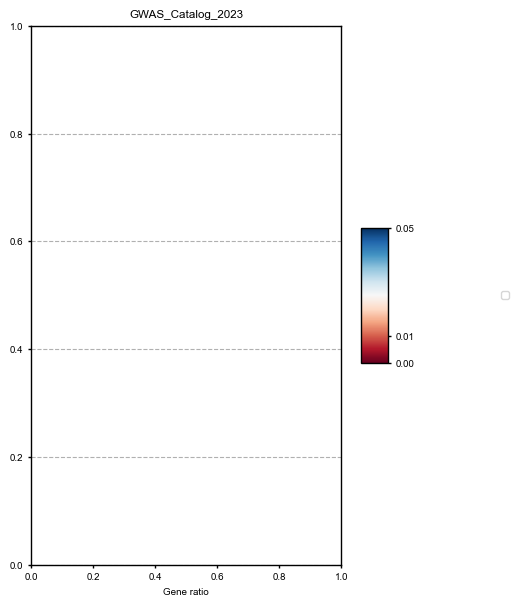

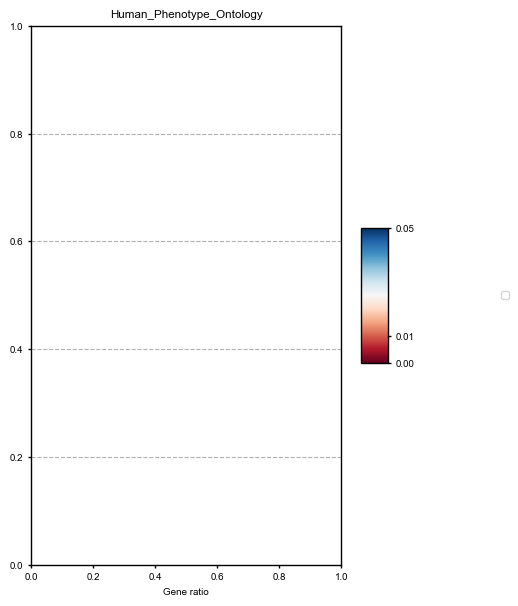

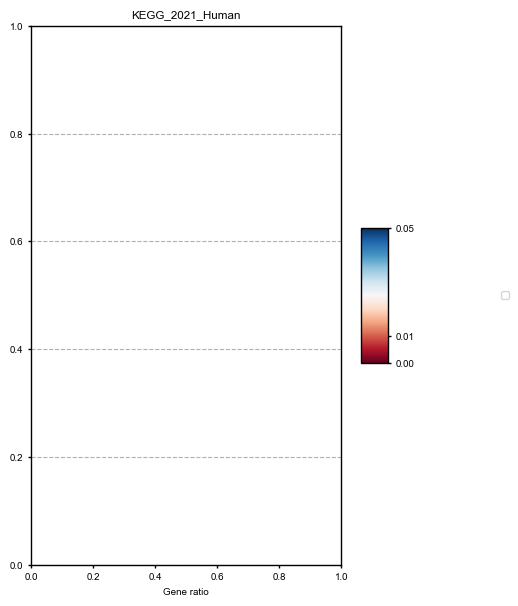

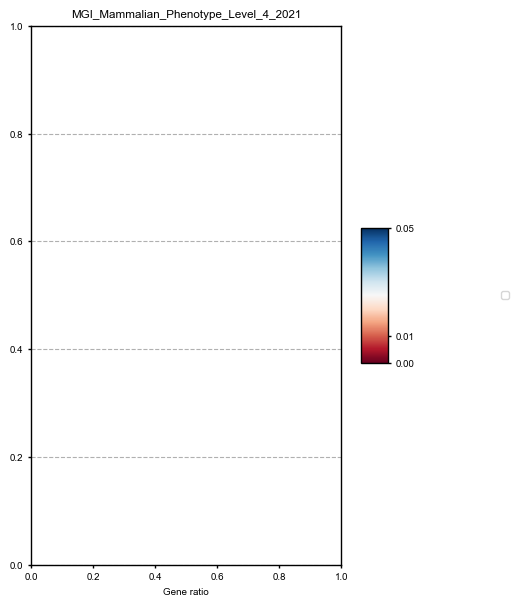

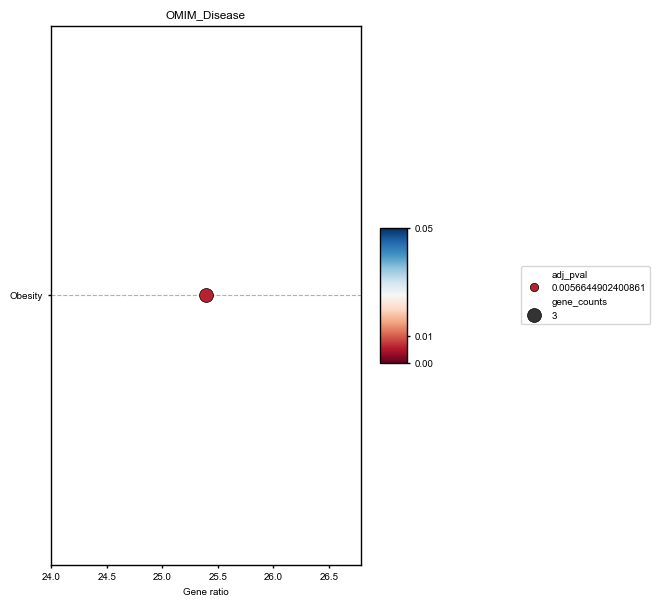

In [22]:
for study, study_genes in zip(["risk", "protective", "meta"], [risk_genes, protective_genes,  all_genes]):
    print(study)
    save_dir_study = os.path.join(save_dir, study)
    os.makedirs(save_dir_study, exist_ok=True)
    run_enrichment(study_genes, pop_genes, save_dir_study)